# Can your yearly compensation be predicted?

<img src="https://cdn.foliomag.com/wp-content/uploads/2018/10/salary.jpg?_ga=2.142752437.1019928373.1543791520-543256937.1543791520" width="300">
## <center><h4>Image from Folio:</h4></center>

# Content
* [Introduction](#intro)
* [Visualize data](#vis)
* [Reorganizing data](#sort)
* [Finding best predictors](#best)
* [Determining relation between predictors and yearly compensation](#mach)
* [Conclusions](#concl)

<a id='intro'></a>
# Introduction

It is commonly believed that a person's salary will improve depending on different factors. For example, it is said that a higher degree of formal education will positively impact your income. Likewise, people affirm that your salary will grow if you have more years of work experience. 

Kaggle 2018 dataset contains a lot of information collected from data scientists around the world. Among all the data, there is information related with current yearly compensation, years of experience, highest level of formal education attained and age. Therefore, this dataset can give insights into the relation that exists between people salary and other information. 

The goal of this job is to find a relation between data scientists yearly compensation and information such as age, years of experience and the highest level of formal education. To achieve this goal, the kaggle dataset is reorganized to get numerical predictors first. Then, data scientists are divided according to their salary in two groups: those with more and those with less salary than a provided number. This is done in order to get a classification problem with two possible classes for the target variable (yearly compensation). After that, variables that best predict the salary are found with ROC and precision-recall figures. Finally, machine learning methods, including logistic regression, are implemented to find a relation between these variables and yearly compensation.

Enjoy this job!!

<a id='vis'></a>
# Visualize data

To start, it is instructive and interesting to take a look at the data from bar charts. These charts constitute a first approximation to understand the scientists' data collected with the kaggle survey. For this job, the attention will be concentrated in yearly compensation, age ranges, highest formal education degree and job experience in years. This section illustrates bar charts related to these variables. 

In [47]:
# Importing neccesary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import itertools
import sklearn.model_selection
import sklearn.linear_model
%matplotlib inline

In [48]:
# Read data
data=pd.read_csv("../input/multipleChoiceResponses.csv",skiprows=[1],low_memory=False)

# Predictors and target
predictors=['Q2','Q4','Q8']
target='Q9'

n_data=data[[target]+predictors].dropna()

In [49]:
def bar_plot(question_data, variable_name, names):
    dic={}
    for name in names:
        dic[name]=sum(question_data==name)
    
    plt.figure(figsize=(10,10))
    plt.barh(range(len(dic)), list(dic.values()), align='center')
    # plt.yticks(range(len(dic)), list(dic.keys()), rotation=90)
    plt.yticks(range(len(dic)), list(dic.keys()), rotation=15)
    plt.xlabel('Number of data scientists')
    plt.ylabel(variable_name)

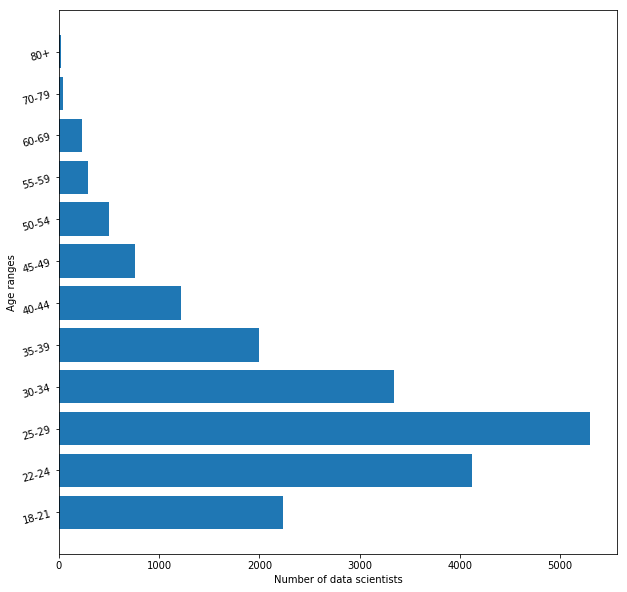

In [50]:
data_q2=np.array(n_data[predictors[0]])
names=sorted(set(data_q2))
bar_plot(data_q2,'Age ranges',names)

From this bar chart, it can be observed that many scientists that answered the kaggle questions are between 22 and 34. Specially greater (more than 5000) is the number of data scientists with an age between 25 and 29 years old that respond to kaggle survey. As the age increases from this age range, the number of data scientists decreases and there are very few people with an age greater than 80. 

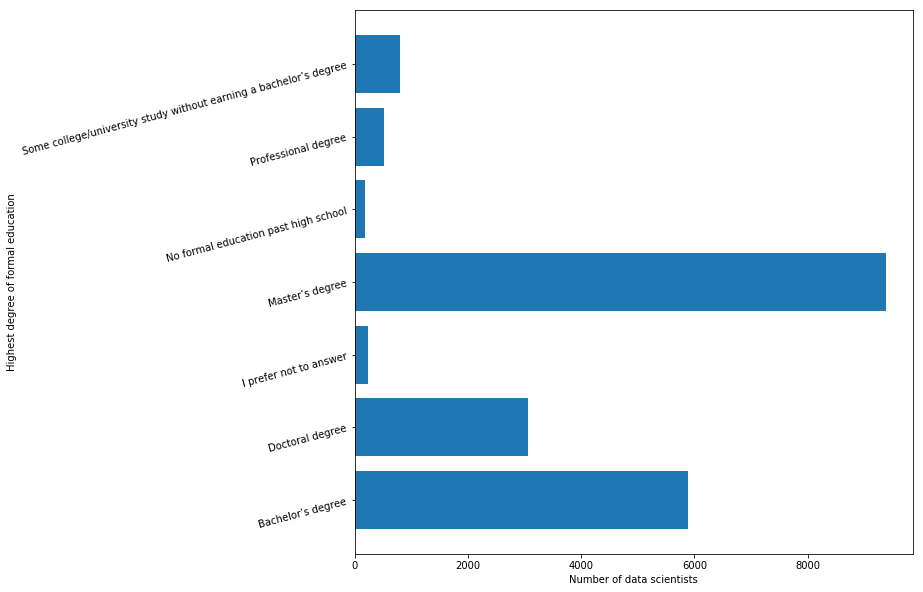

In [51]:
data_q4=np.array(n_data[predictors[1]])
names=sorted(set(data_q4))
bar_plot(data_q4,'Highest degree of formal education',names)

Look at the huge number of masters!! From the bar chart can be concluded that most of the data scientists that answered the survey have bachelor, master or doctoral degree. There are more than 8000 Scientists with a master's degree that answered the kaggle questions. On the other hand, the lowest number of scientists that respond to the survey is obtained from people with no formal education past high school. Also, there are some people who preferred not to answer (in fact, there are more people who preferred not to answer than people with no formal education past high school). These people will not be taking into account when finding relations between variables and yearly compensation

[5, 2, 3, 0, 15, 20, 25, 10, 30, 1, 4]


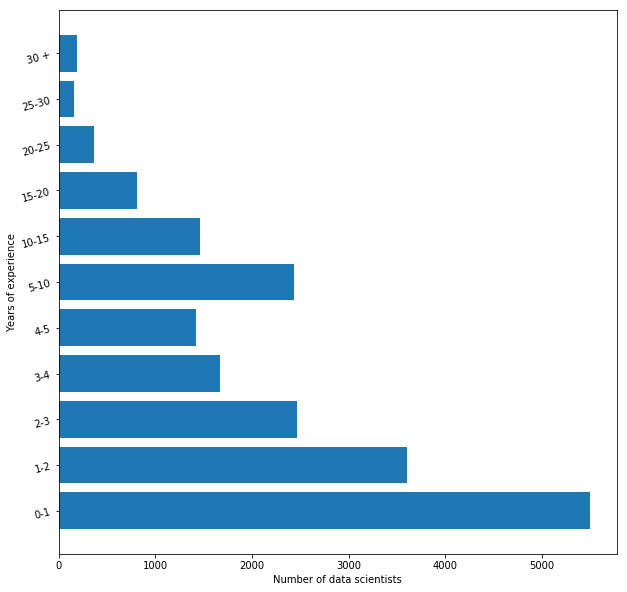

In [52]:
data_q8=np.array(n_data[predictors[2]])

int_name=[]
all_names=np.array(list(set(data_q8)))
for name in set(data_q8):
    if "-" in name:
        inte=int(name.split("-")[0])
    else:
        inte=int(name.split("+")[0])
    int_name.append(inte)
print(int_name)
indx=sorted(range(len(int_name)), key=lambda k: int_name[k])
# bar_plot(data_q8,'Years of experience',)

bar_plot(data_q8, 'Years of experience', all_names[indx])

The bar chart indicates that many scientists with low years of experience respond to the kaggle survey (I would be included here). The number of scientists that answered kaggle questions decrease with increasing years of experience. More than 5000 participants in kaggle survey have between 0 and 1 year of experience. 

In [53]:
# Adjust salary to binary 

orig_salary=n_data[target]

strings=(sorted(set(n_data[target])))
ii=np.array(n_data['Q9']==strings[len(strings)-1])
subset=np.array(n_data[[target]+predictors])[~ii,:]

for i in range(subset.shape[0]):
    if "-" in subset[i,0]:
        max_salary=subset[i,0].split("-")[1]
    else:
        max_salary=subset[i,0].replace("+","")
    
    max_salary=max_salary.replace(",","")
    
    subset[i,0]=int(max_salary)
    

# Create binary array. 1 for people with salary > cut_salary
q9_binary=np.zeros(subset.shape[0])
cut_salary=150000
q9_binary[subset[:,0]>cut_salary]=1

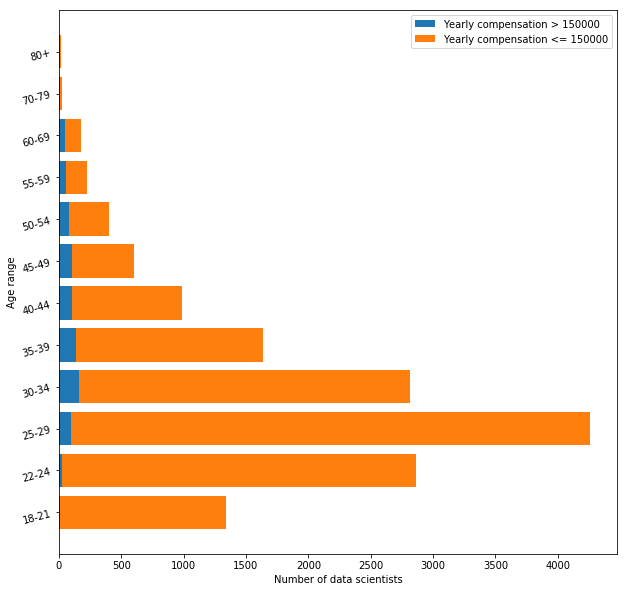

In [54]:
def bar_plot_compensation(question_data, target_binary_data, variable_name, names, cut_salary):
    dic_greater={}
    dic_lower={}
    for name in names:
        cond1=np.array(question_data==name)
        dic_greater[name]=sum(cond1 & (target_binary_data==1))
        dic_lower[name]=sum(cond1 & (target_binary_data==0))
    
    plt.figure(figsize=(10,10))
    # plt.barh(range(len(dic)), list(dic.values()), align='center')
    # plt.yticks(range(len(dic)), list(dic.keys()), rotation=90)
    
    p1 = plt.barh(range(len(dic_greater)), list(dic_greater.values()))
    p2 = plt.barh(range(len(dic_lower)), list(dic_lower.values()), left=list(dic_greater.values()))
    
    plt.yticks(range(len(dic_greater)), list(dic_greater.keys()), rotation=15)
    plt.xlabel('Number of data scientists')
    plt.ylabel(variable_name)
    
    plt.legend((p1[0], p2[0]), ('Yearly compensation > %d'%cut_salary, 'Yearly compensation <= %d'%cut_salary))


data_q2=np.array(n_data[predictors[0]])
question_data=subset[:,1]
target_binary_data=q9_binary
variable_name='Age range'
names=sorted(set(data_q2))

bar_plot_compensation(question_data, target_binary_data, variable_name, names, cut_salary)

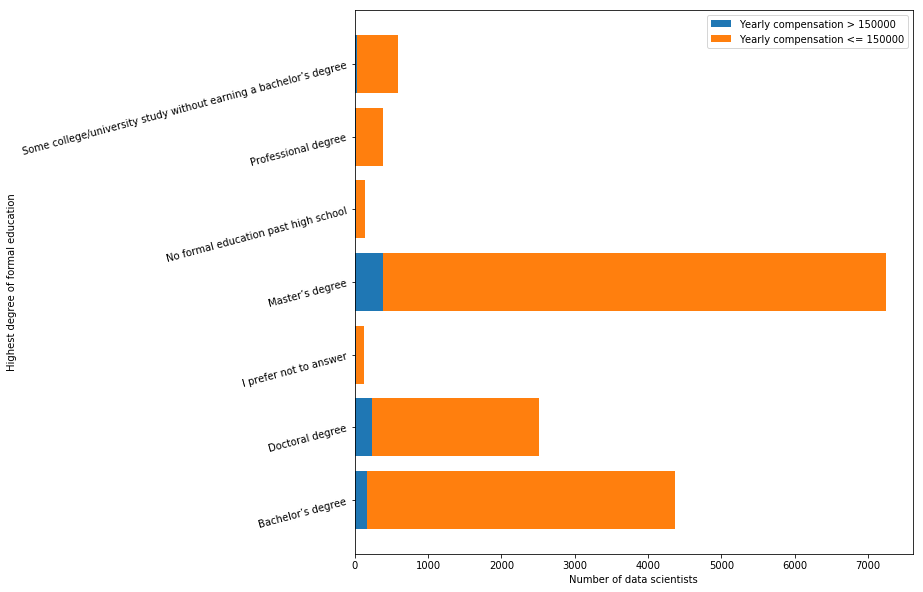

In [55]:
data_q4=np.array(n_data[predictors[1]])

question_data=subset[:,2]
target_binary_data=q9_binary
variable_name='Highest degree of formal education'
names=sorted(set(data_q4))

bar_plot_compensation(question_data, target_binary_data, variable_name, names, cut_salary)

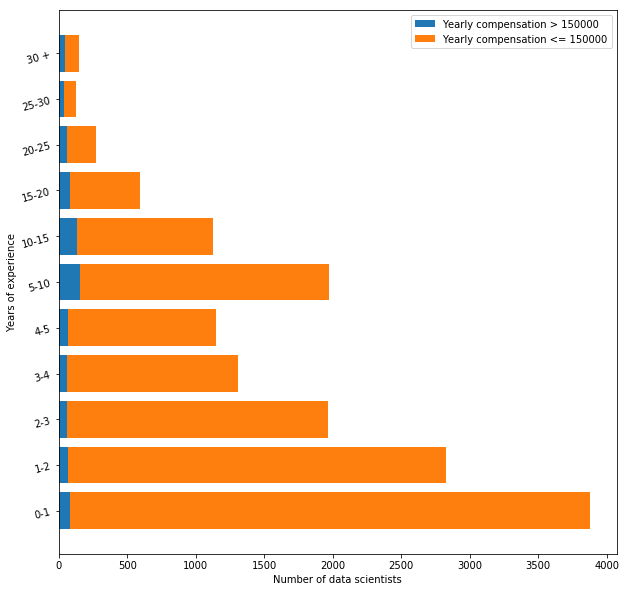

In [56]:
data_q8=np.array(n_data[predictors[2]])

int_name=[]
all_names=np.array(list(set(data_q8)))
for name in set(data_q8):
    if "-" in name:
        inte=int(name.split("-")[0])
    else:
        inte=int(name.split("+")[0])
    int_name.append(inte)
indx=sorted(range(len(int_name)), key=lambda k: int_name[k])

question_data=subset[:,3]
target_binary_data=q9_binary
variable_name='Years of experience'
names=all_names[indx]

bar_plot_compensation(question_data, target_binary_data, variable_name, names, cut_salary)

Stop for a moment and look at the bar charts in detail. For example, in the age range bar chart, it can be seen that scientists with ages between 60 and 69 have better yearly compensations. Even though blue zone appears to be less compared with other age ranges, the proportion between the scientists who earn better yearly compensations and the total scientists with ages in this range is higher compared with this proportion in lower age ranges. 
As expected, yearly compensation tends to increase with the number of experience years, with a better formal education degree and with age.

<a id='sort'></a>
# Reorganizing data

In [57]:
n_data=data[[target]+predictors].dropna()

To apply machine learning methods to the data set, variables must be changed from strings to numbers. Therefore, here is presented the reorganization performed to achieve this goal. Related with the age variable, the value taken is the lower age in every age range. This value will be implemented in the prediction of yearly compensation.

In [58]:
# Adjust age, taking lower age in age range as parameter
age='Q2'
orig_age=np.array(n_data[age])
n_ages=np.zeros(len(orig_age))

for i in range(len(orig_age)):
    if "-" in orig_age[i]:
        str_age=orig_age[i].split("-")[0]
    else:
        str_age=orig_age[i].replace("+","")
    n_ages[i]=int(str_age)
    
n_data[age]=n_ages

As with age data, it is considered only the lower number in the range of experience years for every scientist. 

In [59]:
# Adjust experience years, taking lower experience years in years range as parameter
years='Q8'
orig_years=np.array(n_data[years])
n_years=np.zeros(len(orig_years))

for i in range(len(orig_years)):
    if "-" in orig_years[i]:
        str_years=orig_years[i].split("-")[0]
    else:
        str_years=orig_years[i].replace("+","")
    n_years[i]=int(str_years)
    
n_data[years]=n_years

To handle a target with two possible classification classes, scientists are divided in two groups. The first and the second group includes people with yearly compensation lower and greater than a cut yearly compensation (in this case 150 000), respectively. 

In [60]:
# Adjust salary to binary 
orig_salary=n_data[target]

strings=(sorted(set(n_data[target])))
ii=np.array(n_data['Q9']==strings[len(strings)-1])
subset=np.array(n_data[[target]+predictors])[~ii,:]

for i in range(subset.shape[0]):
    if "-" in subset[i,0]:
        max_salary=subset[i,0].split("-")[1]
    else:
        max_salary=subset[i,0].replace("+","")
    
    max_salary=max_salary.replace(",","")
    
    subset[i,0]=int(max_salary)
    

# Create binary array. 1 for people with salary > cut_salary
q9_binary=np.zeros(subset.shape[0])
cut_salary=150000
q9_binary[subset[:,0]>cut_salary]=1

subset[:,0]=q9_binary

Finally, the organization of highest formal education degree data is different. A number is assigned to each different degree name. As a consequence, all bachelors will be denoted by a common number, and the same applies for all the other possible formal education degrees. 

In [61]:
# Ajust degree to numerical data
def string2numeric(data):
    dic={}
    values=sorted(set(data))
    cont=0
    for value in values:
        dic[value]=cont
        cont+=1;
    numeric=[dic[item] for item in data]
    return numeric, dic

n_deg,n_deg_dic=string2numeric(subset[:,2])
subset[:,2]=n_deg

<a id='best'></a>
# Finding best predictors

To find the variables that best predict yearly compensation, ROC and precision-recall figures are implemented. The general idea is that the combination of predictors that give a result with the highest ROC and precision-recall areas will be the predictors that best predict the target variable. To find these areas, a machine learning method must be implemented after splitting the data into training and test sets. Then, the values of precision, recall, true and false positive rates can be found and, therefore, the ROC and precision-recall curves. Comparing all the areas computed from all the possible combinations of predictors allows to find the variables that best predict yearly compensation. The functions defined in this section carry out this work.

In [62]:
# Find the most important predictors according to ROC and Precision-recall areas from logistic regression

'''
Function to find areas of ROC and precision-recall figures
'''
def roc_pr_areas(data_predictors,data_target, method):
    # Split in train and test
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data_predictors,data_target, test_size=0.4)
    
    # 
    method.fit(X_train,Y_train)
    y_predict=method.predict_proba(X_test)[:,1]
    
    conf_matrix=np.zeros((2,2))
    
    threshold=np.linspace(0.1,0.8,100)
    pts_roc=np.zeros((len(threshold),2))
    pts_pr=np.zeros((len(threshold),2))
    
    for i in range(len(threshold)):
    
        for j in range(len(y_predict)):
            
            if y_predict[j]>threshold[i]:
                if Y_test[j]==1:
                    conf_matrix[0,0]+=1
                else:
                    # False positive
                    conf_matrix[0,1]+=1
            else:
                if Y_test[j]==0:
                    conf_matrix[1,1]+=1
                else: 
                    # False negative
                    conf_matrix[1,0]+=1
        
        tp=conf_matrix[0,0]
        fp=conf_matrix[0,1]
        tn=conf_matrix[1,1]
        fn=conf_matrix[1,0]
        # pts_roc= false positive rate, true positive rate = fp/(fp+tn), tp/(tp+fn)
        pts_roc[i,:]=fp/(fp+tn), tp/(tp+fn)
        
        # pts_pr= recall, precision = tp/tp+fn, tp/tp+fp
        pts_pr[i,:]=tp/(tp+fn), tp/(tp+fp)
    
    # compute the area under precision recall curve
    ii = np.argsort(pts_roc[:,0])
    iii=ii[0:10]
    roc_area=scipy.integrate.trapz(pts_roc[ii,1],pts_roc[ii,0])
    
    # compute the area under precision recall curve
    ii = np.argsort(pts_pr[0,:])
    pr_area=scipy.integrate.trapz(pts_pr[ii,1],pts_pr[ii,0])  
    
    return roc_area, pr_area
    
    
    
'''
Function to find variables that best predict the target
'''
def best_predictors(data_predictors,data_target, method, predictor_names):
    n_predictors=len(predictor_names)
    highest_roc_area=0
    highest_pr_area=0
    best_predictors=np.array([''])
    for i in range(n_predictors):
        combinations = itertools.combinations(np.arange(0,n_predictors), i+1)
        for comb in combinations:
            roc_area, pr_area= roc_pr_areas(data_predictors,data_target, method)
            #print('roc_area=', roc_area, 'for combination', predictor_names[list(comb)],  'and pr_area=', pr_area)
            if roc_area>highest_roc_area and pr_area>highest_pr_area:
                highest_roc_area=roc_area
                highest_pr_area=pr_area
                best_predictors=predictor_names[list(comb)]
                print("New predictors=",best_predictors)
    return best_predictors

In [63]:
data_predictors=subset[:,1:]
data_target=np.array(subset[:,0], dtype=int)
f = sklearn.linear_model.LogisticRegression(solver='lbfgs')
predictors=np.array(['Q2','Q4','Q8'])

n_predictors=best_predictors(data_predictors,data_target,f, predictors)
print('Best predictors with logistic regression:',n_predictors)

New predictors= ['Q2']
Best predictors with logistic regression: ['Q2']


<a id='mach'></a>
# Determining relation between predictors and yearly compensation

To find the possible relation between the yearly compensation and the best predictors found previously, different machine learning methods are presented in this section. The aim of every machine learning method is to find the formula, with its respective coefficients, from which yearly compensation can be predicted. The best predictors for the logistic regression method were found previously, but with the other methods the best predictors can change. As a consequence, with every different machine learning method the functions defined in the previous section must be called again. Moreover, when these functions are called again with the same method the best predictors set can change because of the training and test split. Therefore, the code and one result are presented, but in the conclusions section the general trends will be described.

## Logistic regression

In [64]:
# Get predictor columns as dictionary and get best predictors from subset data
predictors_cols_dic={}
for i in range(len(predictors)):
    predictors_cols_dic[predictors[i]]=i
predictors_subset=subset[:,1:]
target_subset=np.array(subset[:,0],dtype=int)

# Get best predictors subset
ii=[predictors_cols_dic[name] for name in n_predictors]
best_subset=predictors_subset[:,ii]

In [65]:
# Find relation between best predictor and target
nf = sklearn.linear_model.LogisticRegression(solver='lbfgs')
nf.fit(best_subset,target_subset)
print("Coefficients: ",nf.coef_)

Coefficients:  [[0.08408151]]


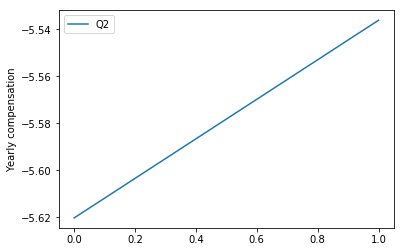

In [66]:
for i in range(nf.coef_.shape[1]):
    y=nf.intercept_+nf.coef_[:,i]
    plt.plot([0,1],[nf.intercept_,y],label=n_predictors[i])
plt.ylabel('Yearly compensation')
plt.legend()

## Linear Discriminan Analysis

In [67]:
import sklearn.discriminant_analysis

f = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()

n_predictors=best_predictors(data_predictors,data_target,f, predictors)
print('Best predictors with LDA:',n_predictors)

New predictors= ['Q2']
New predictors= ['Q4']
Best predictors with LDA: ['Q4']


In [68]:
'''
Function to plot relation between best predictors and yearly compensation
'''
def plot_best_predictors(method, best_subset, target_subset, n_predictors):
    method.fit(best_subset,target_subset)

    for i in range(method.coef_.shape[1]):
        y=method.intercept_+method.coef_[:,i]
        plt.plot([0,1],[method.intercept_,y],label=n_predictors[i])
    plt.ylabel('Yearly compensation')
    plt.legend()

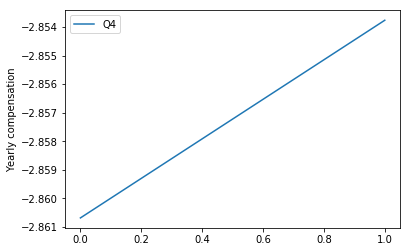

In [69]:
# Find relation between best predictor and target with LDA
method=sklearn.discriminant_analysis.LinearDiscriminantAnalysis()

ii=[predictors_cols_dic[name] for name in n_predictors]
best_subset=predictors_subset[:,ii]

plot_best_predictors(method, best_subset, target_subset, n_predictors)

<a id='concl'></a>
# Conclusions


After running multiple times the code, the set of best predictors can change, but always the same relations are found: yearly compensation grows with an increase in age and years of experience. On the other hand, yearly compensation decreases slowly with increments in the values for the highest degree of formal education, defined within the dictionary. This dictionary is as follows:

In [70]:
print(n_deg_dic)

{'Bachelor’s degree': 0, 'Doctoral degree': 1, 'I prefer not to answer': 2, 'Master’s degree': 3, 'No formal education past high school': 4, 'Professional degree': 5, 'Some college/university study without earning a bachelor’s degree': 6}


Based on this, the result is expected since greater values in the dictionary corresponds to lower levels of formal education. Moreover, the common believes presented in the introduction are supported by kaggle dataset. Logistic regression and linear discriminant analysis seem to work well predicting yearly compensation from age, experience and formal education degree.